1/1 [==============================] - 0s 317ms/step
Original Content Image:


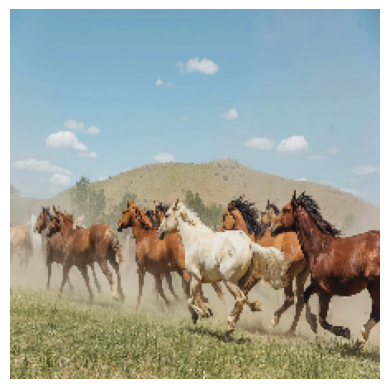

Visualizing features from layer: block1_conv1


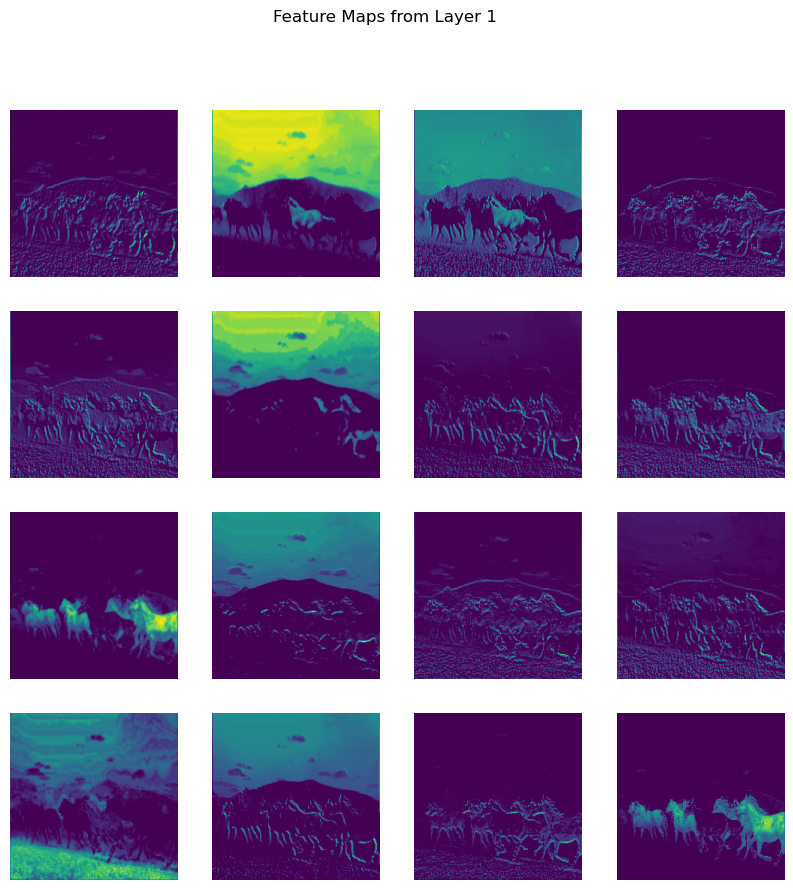

Visualizing features from layer: block2_conv1


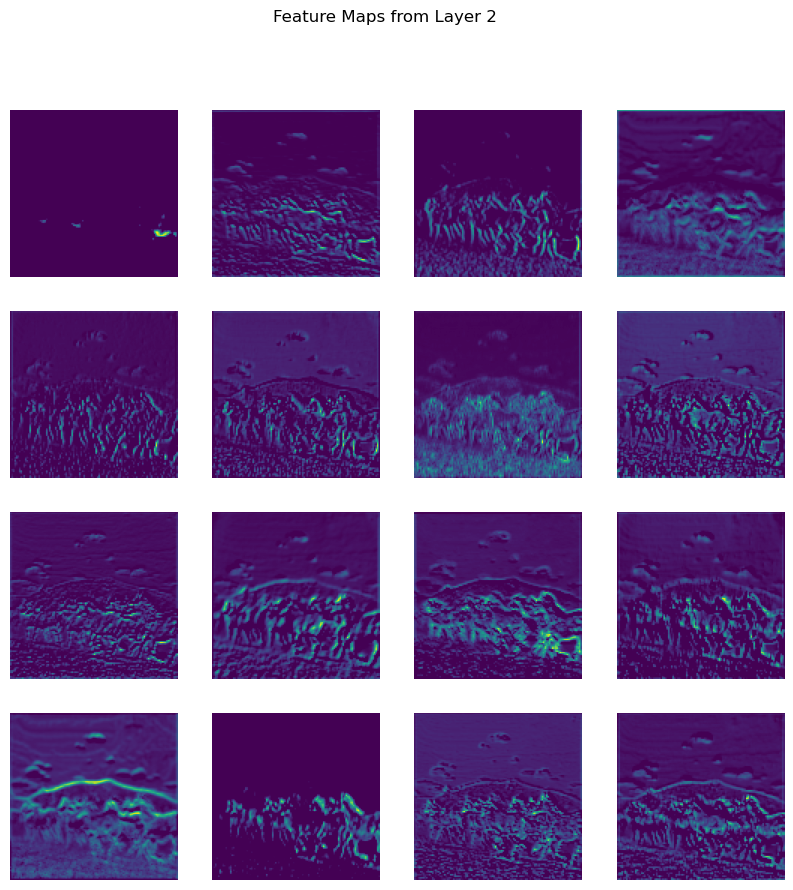

Visualizing features from layer: block3_conv1


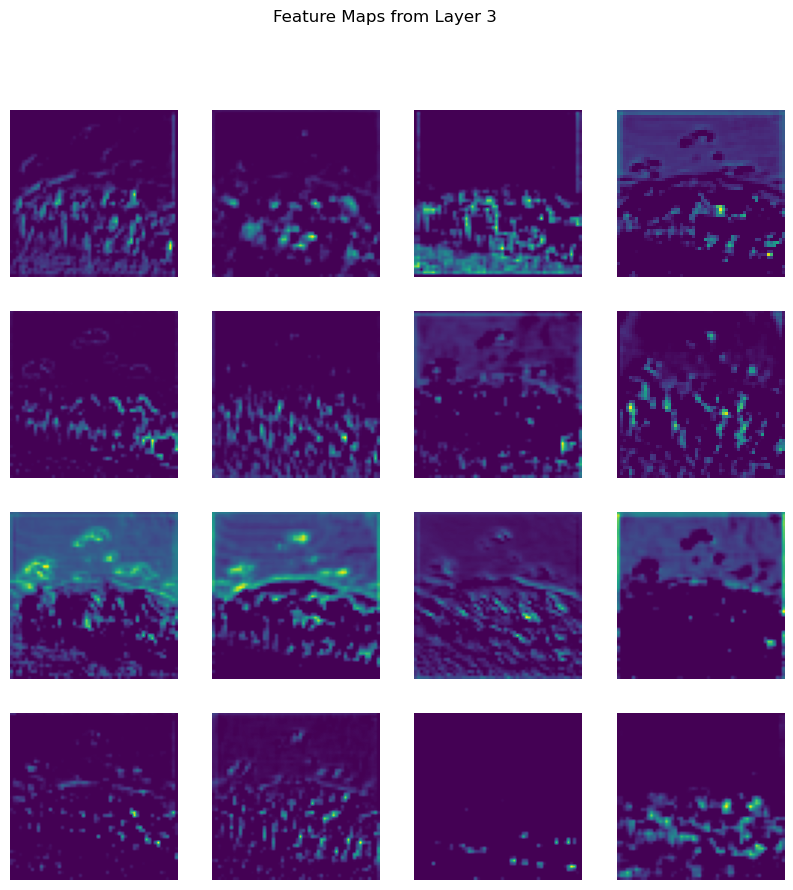

Visualizing features from layer: block4_conv1


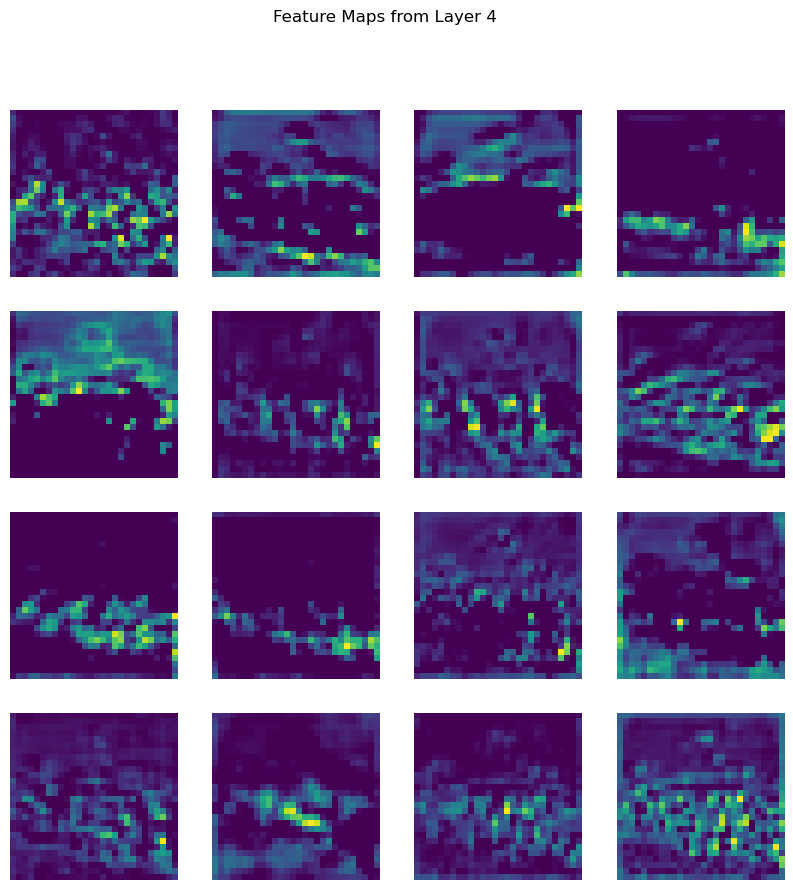

Visualizing features from layer: block5_conv1


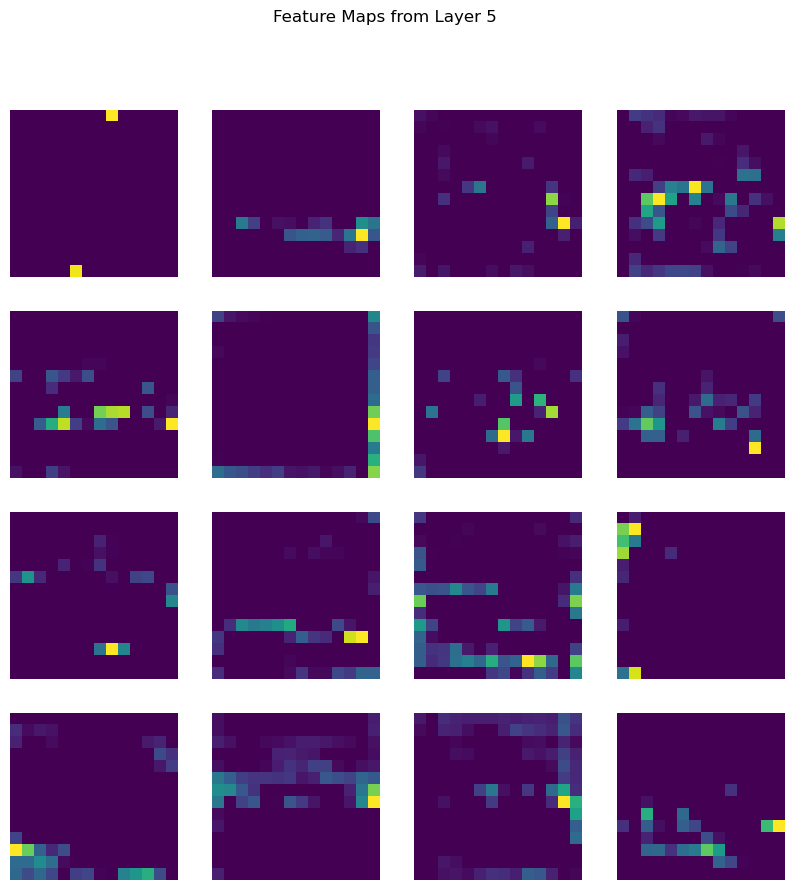

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# De-process image (for display purposes)
def deprocess_image(processed_img):
    img = processed_img.copy()
    if img.ndim == 4:
        img = img[0]  # Remove batch dimension
    
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Display the image
def display_image(image_tensor):
    img = deprocess_image(image_tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Load VGG19 model
vgg19_model = VGG19(weights='imagenet', include_top=False)

# Extract features from the model, you can select any layer you like
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create a model that outputs the selected layers
outputs = [vgg19_model.get_layer(name).output for name in layer_names]
feature_model = Model(inputs=vgg19_model.input, outputs=outputs)

# Load the image
image_path = '../sources/image-1.png'  # Replace with your image path
content_image = load_and_preprocess_image(image_path)

# Extract features
features = feature_model.predict(content_image)

# Visualize features
def visualize_features(features, layer_index, num_maps=16):
    feature_map = features[layer_index]
    num_filters = feature_map.shape[-1]  # Number of filters in the layer
    
    # Display the first `num_maps` feature maps for the selected layer
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))  # Creating a 4x4 grid for 16 filters
    fig.suptitle(f"Feature Maps from Layer {layer_index+1}")
    
    for i in range(num_maps):
        ax = axs[i // 4, i % 4]
        ax.imshow(feature_map[0, :, :, i], cmap='viridis')
        ax.axis('off')
    
    plt.show()

# Display the original content image
print("Original Content Image:")
display_image(content_image)

# Visualize features from each selected layer
for i, layer_name in enumerate(layer_names):
    print(f"Visualizing features from layer: {layer_name}")
    visualize_features(features, layer_index=i)

1/1 [==============================] - 0s 69ms/step
Reconstructed Image:


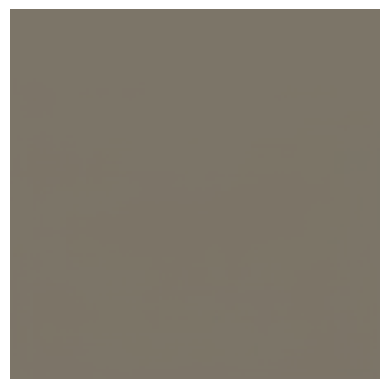

In [7]:
# Decoder function to reconstruct the image from features of shape (14, 14, 512)
def build_decoder():
    decoder = Sequential()
    
    decoder.add(Conv2D(512, (3, 3), padding='same', input_shape=(7, 7, 512), activation='relu'))
    decoder.add(UpSampling2D((2, 2)))
    
    decoder.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    decoder.add(UpSampling2D((2, 2)))
    
    decoder.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    decoder.add(UpSampling2D((2, 2)))
    
    decoder.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    decoder.add(UpSampling2D((2, 2)))
    
    # Final layer to output the image with 3 channels (RGB)
    decoder.add(Conv2D(3, (3, 3), padding='same', activation='sigmoid'))  # Sigmoid to constrain output to [0, 1]
    
    return decoder

# Build the decoder
decoder = build_decoder()

# Reconstruct the image from the highest-level features (features[-1] -> block5_conv1)
decoded_image = decoder.predict(features[-1])

# Display the reconstructed image
print("Reconstructed Image:")
display_image(decoded_image)